# Lecture 19 - Natural Language Generation

In this notebook we will learn how to generate natural language using transformer language models.

Below is the overview of this notebook.

1. Test different decoding methods on GPT-2

2. Fine tune GPT-2 to tweet like a Twitter user

3. Generate controlled text using CTRL

In [6]:
markdown
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

SyntaxError: invalid syntax (<ipython-input-6-b4d73bdd6f26>, line 2)

In [ ]:
!pip install transformers

In [2]:
from transformers import AutoTokenizer,AutoModelForCausalLM
from transformers import pipeline

import sqlite3, sys, os
import pandas as pd
import scripts.TextAnalysis as ta
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter 

import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

We will use the function `display_text` to display the output generated text.

In [3]:
def display_text(outputs):
    for count,output in enumerate(outputs):
        text = output['generated_text']
        text = text.replace("\n"," ").replace("\r"," ")
        print(f"{count}: {text}")
    return None

# Decoding Methods

We will begin by testing diffrenent decoding methods for generating text from a language model.  The methods include

1. Greedy search

2. Beam search

3. Sampling

4. Sampling with temperature

5. Top-k sampling

6. Top-p sampling 

Much of this code comes from the following blog:

https://huggingface.co/blog/how-to-generate

## Load GPT-2

We will be generating text using the GPT-2 transformer.  We set `model_name = "gpt-2"` and then create `generator` with the `pipeline` function.  `generator` will be a function that lets us generate text very easily once we specify a model.  It automatically loads the proper tokenizer for the model, tokenizes the text, and generates the text.  

In [4]:
%%time
model_name = "gpt2"
generator = pipeline('text-generation',model=model_name)

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wall time: 9.63 s


## Set Input Parameters

We need to set some input parameters to generate text.

1. `input_text` = the starting text string for your generated text

2. `max_length` = the number of words in your generated text

3. `num_return_sequences` = number of texts you want to generate (this is for the sampling methods)

In [43]:
input_text = "Joe Biden's infrastructure bill is"
max_length = 30
num_return_sequences = 5

## Greedy Search

To use greedy search, we call `generator` with the `input_text`, `max_length`, and set `do_sample=False`.  The output of `generator` is `outputs` which is a list of the generated text objects.  We use `display_text` to print out the generated text. If you want to learn about the exact structure of `outputs`, you can look at the details of `display_text`.

In [44]:
outputs =generator(input_text, 
                         max_length=max_length, 
                           do_sample = False,
                        pad_token_id = 50256)

print(f"Greedy search\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Greedy search
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is a disaster. It's a disaster for the American people. It's a disaster for the American economy. It's a


## Beam Search

To use beam search we have to set the number of beams `num_beams`.  Then we use `generator` with a few additional parameters:

1. `early_stopping=True` so that generation is finished when all beams reach the End Of Sentence (EOS) token.

2. `num_beams=num_beams` so we track `num_beams` beams while generating the text.

In [45]:
num_beams = 5

outputs = generator(input_text, 
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_beams=num_beams, 
                        early_stopping=True,
                        do_sample = False
                        )

print(f"Beam search with {num_beams} beams:\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Beam search with 5 beams:
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is a disaster. It's a disaster for the American people. It's a disaster for our economy. It's a disaster


## Sampling

To generate text by sampling from the language model, we call `generator` with the following parameters:

1. `do_sample = True`

2. `num_return_sequences=num_return_sequences` because we will be generating multiple texts.

In [46]:
outputs = generator(input_text, 
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_return_sequences=num_return_sequences,
                         do_sample=True
                        )

print(f"Sampling\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Sampling
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is far too big to pass without bipartisan support and is too controversial to pass.  As Democrats look to replace Obamacare with
1: Joe Biden's infrastructure bill is an example of how the two can coexist on a budget. It will be difficult for Democrats to stop Republicans from appropri
2: Joe Biden's infrastructure bill is a disaster, a disaster for America, a disaster only for President Obama. If you take a look at the budget,
3: Joe Biden's infrastructure bill is a complete sh*t on defense. No longer are we allowed to have one-sided debates with people who have nothing
4: Joe Biden's infrastructure bill is "about creating an open" environment for jobs and investment, said a spokeswoman for Clinton's campaign.  In a


## Sampling with Temperature

Sampling with temperature requires us to set the `temperature`.  Setting `temperature=1` is equivalent to normal sampling from the language model.  Setting `temperature=0` is equivalent to greedy search.   If you set `temperature` to be greater than 1, you will get more random text, while if `temperature` is less than 1 you get higher probability text.  

We use `generator` with the same parameters as for sampling, but with an additional parameter:

1. `temperature = float(temperature)`.  We need `temperature` to be a float number for the code to work.


In [47]:
temperature = 1.2

outputs = generator(input_text, 
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_return_sequences=num_return_sequences,
                         do_sample=True,
                         temperature = float(temperature)
                        )

print(f"Sampling with temperature = {temperature}\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Sampling with temperature = 1.2
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is almost certainly a bad deal for the American workers that they need to build the most successful economic policy in the world," said
1: Joe Biden's infrastructure bill is already working against his Republican friends in the Republican-controlled New Hampshire legislature.  In an effort to counter the Trump
2: Joe Biden's infrastructure bill is a disaster  It's hard to argue it can't go through Congress. And some critics have been right at the
3: Joe Biden's infrastructure bill is to take up an Obama budget proposal by the mid-2020s which is now expected to go on the House floor.
4: Joe Biden's infrastructure bill is coming out soon, with the Democrats planning to consider several parts. In 2015, Obama pledged for $3 trillion in tax


## Top-k Sampling

We first set `k` equal to the size of the sampling set of words.  Then we call generator with the same parameters as for sampling or sampling with temperature, plus one additional parameter:

1. `top_k=k`

In [48]:
k = 5

outputs = generator(input_text,
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_return_sequences=num_return_sequences,
                         do_sample=True, 
                        top_k=k,
                        )

print(f"Top-k Sampling with k = {k}\nModel = {model_name}\n"+ 50*"-")
display_text(outputs)

Top-k Sampling with k = 5
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is not a slam dunk. It is a step towards the end of a long and storied career.  The House
1: Joe Biden's infrastructure bill is not a good idea. It's a bad idea that's been on the table for years.  The only thing
2: Joe Biden's infrastructure bill is the most ambitious in recent history.  It would create a new, three-state highway that would connect New Jersey
3: Joe Biden's infrastructure bill is a good idea. He's a strong advocate of building the Keystone pipeline. But the Keystone project is a bad idea for
4: Joe Biden's infrastructure bill is a big deal. It will help keep America's jobs and create more jobs. It will help us build the infrastructure that


## Top-p Sampling

We first set `p` to be the probability of words in the sample set.  Then we call generator with the same parameters as for sampling or sampling with temperature, plus one additional parameter:

1. `top_p = p`


In [49]:
p=0.92
temperature = 0.7

outputs = generator(input_text, 
                         max_length=max_length,
                        pad_token_id = 50256,                         
                        num_return_sequences=num_return_sequences,
                         do_sample=True, 
                       temperature = float(temperature),
                        top_p = p
                        )

print(f"Top-p Sampling with p = {p:.3f}\nModel = {model_name}\n" + 50*"-")
display_text(outputs)

Top-p Sampling with p = 0.920
Model = gpt2
--------------------------------------------------
0: Joe Biden's infrastructure bill is not the first time the president has criticized Democrats for their record on infrastructure.  In September, Trump told MSNBC's
1: Joe Biden's infrastructure bill is also about the fact that it's not just about getting infrastructure built. It's about getting the money out of the hands
2: Joe Biden's infrastructure bill is "just another one in a long series of promises that have been made by Republicans that will be dashed if they lose the
3: Joe Biden's infrastructure bill is a major victory for the left, who have been increasingly frustrated with the Democrats' inability to deliver on their promise to spend
4: Joe Biden's infrastructure bill is "a disaster," says Democratic pollster Dan Drezner. "The President is doing something he's not expected to


# Generating Synthetic Tweets

## Fine Tune GPT-2 on a Twitter User's Tweets

We are next going to fine tune GPT-2 using the tweets of a Twitter user.  We can do this using the following notebook found on Google Colab:
https://colab.research.google.com/github/borisdayma/huggingtweets/blob/master/huggingtweets-demo.ipynb#scrollTo=CpxBQYF88AHJ
Just follow the instructions on the notebook to fine tune GPT-2.  The model will then be saved to the HuggingTweets repository.  You will need a Google account to use the notebook. 

Details about this code can be found here:
https://wandb.ai/wandb/huggingtweets/reports/HuggingTweets-Train-a-Model-to-Generate-Tweets--VmlldzoxMTY5MjI



## Load a Fine-Tuned Model from HuggingTweets

There are many pre-trained models on HuggingTweets: https://huggingface.co/huggingtweets.  To choose one, set `screen_name` equal to the Twitter user whose model you want to use.  Then created `generator_tweet` using the `pipeline` function.


In [5]:
screen_name = "AOC"
generator_tweet = pipeline('text-generation',
                     model=f"huggingtweets/{screen_name.lower()}")



Downloading:   0%|          | 0.00/908 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

## Generate Tweet in Voice of a Twitter User

Use `generator_tweet` to generate tweets in the voice of the Twitter user.  Just set the input parameters:

1. `input_text_tweet` = starting text of tweet

2. `max_length` = number of words in tweet

3. `num_return_sequences` = number of tweets to generate

4. `temperature` = temperature for sampling

5. `p` = probability of sample set for top-p sampling

In [51]:
input_text_tweet = "Today"
max_length = 30
num_return_sequences = 5
temperature = 0.8
p = 0.95

outputs =generator_tweet(input_text_tweet, 
                       max_length=max_length,
                       num_return_sequences= num_return_sequences,
                       temperature = float(temperature),
                       do_sample = True,
                       top_p = p,
                       pad_token_id=50256,
                  no_repeat_ngram_size=2,)

print(f"Fake Tweets of {screen_name}\n"+50*"-")
display_text(outputs)

Fake Tweets of brianstelter
--------------------------------------------------
0: Today's post is about how Trump has handled his own coronavirus coronaviage and the coroncavian coronautics trial. Read on
1: Today, the country's first pro-Trump newspaper, The Washington Post, announced that it is leaving the paper after just one year. The move comes
2: Today, the country's top news networks are airing the first of four TV interviews with Trump in a week: his inauguration, his coronavirus pand
3: Today's edition of CNN is live on @CNN, with interviews from @danaherr, @danfron and @LizNYT
4: Today: @bkirby writes about how "the rise of the Republican party has been led by a surge in extreme right-wing violence"


# Language Model Probability Distribution

To explore the fine tuned language model, we can plot the probability distribution of the next word given an input text.  We do this as follows.

1. Choose your input text

2. Sample many words from the language model given the input text

3. Make a histogram of the sampled words

## Helper function

The function `sample_words` will sample words from the language model given an input text.  It's input parameters are 

1. `input_text` = input text 

2. `generator` = language model generator from which you will be sampling words

3. `nsamples` = number of words to sample


`sample_words` returns a dataframe with columns `word` which has the words and `freq` which has the frequency count for the sampled words.

In [60]:
def sample_words(input_text,generator,nsamples):
    max_length = len(input_text.split(" "))+1
    outputs = generator(input_text, 
                             max_length=max_length,
                            pad_token_id = 50256,                         
                            num_return_sequences=nsamples,
                             do_sample=True, 
                            top_k=0
                            )

    W = []
    for count,output in enumerate(outputs):
        text = output['generated_text']
        text = text.replace("\n"," ").replace("\r"," ").replace(input_text,"")
        W.append(text)
    counter = Counter(W)

    words = [x for x in counter.keys()]
    freqs = [x for x in counter.values()]

    df_freq = pd.DataFrame({'word':words,'freq':freqs})
    df_freq.sort_values(by = 'freq', ascending = False, inplace = True)
    df_freq.head()
    return df_freq




## Sample Words from GPT-2 and Fine Tuned GPT-2

Set the input text with the variable `input_text_sample`.  It's important not to put a space at the end of `input_text_sample` because of the way the generated sequence length is calculated.  Then sample `nsamples` words from the GPT-2 generator, called `generator`, and the fined tuned GPT-2 generator, called `generator_tweet`. 

The dataframe with the word frequencies for GPT-2 is called `df_gpt2` and the dataframe with the word frequencies for fined tuned GPT-2 is called `df_gpt2_ft`

In [71]:
%%time 

input_text_sample = 'Today a fake'
nsamples = 1000

df_gpt2 =  sample_words(input_text_sample, generator,nsamples)
df_gpt2_ft = sample_words(input_text_sample, generator_tweet, nsamples)


Wall time: 28.8 s


## Histograms of Word Distributions for GPT-2 and Fined Tuned GPT-2

To visualize the difference in the distributions for GPT-2 and fine tuned GPT-2, make a histogram of the sampled words for the two models.

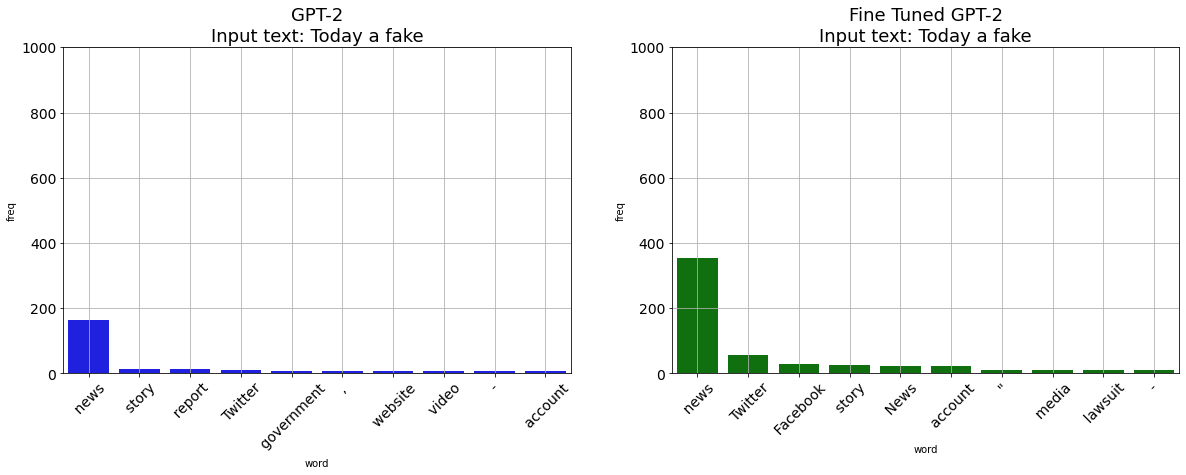

In [74]:
wmax = 10
rot = 45
ymax = nsamples

fig = plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
ax = sns.barplot(data = df_gpt2[0:wmax], x = 'word', y = 'freq', color = 'blue')
plt.title(f"GPT-2\nInput text: {input_text_sample}",fontsize = 18)
ax.set_xticklabels(ax.get_xticklabels(),rotation = rot)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.ylim([0,ymax])

plt.subplot(1,2,2)
ax=sns.barplot(data = df_gpt2_ft[0:wmax], x = 'word', y = 'freq', color = 'green')
plt.title(f"Fine Tuned GPT-2\nInput text: {input_text_sample}",fontsize = 18)

ax.set_xticklabels(ax.get_xticklabels(),rotation = rot)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.ylim([0,ymax])

plt.show()

# Controlled Natural Language Generation: CTRL

We will use CTRL to generaate controlled text.  The original CTLR paper can be found here: https://arxiv.org/pdf/1909.05858.pdf


## Load CTRL

Set `model_name="ctrl"` and then created `generator_ctrl` using the `pipeline` function.

WARNING: CTRL is pretty big (~6 GB) so this step may take a few minutes.



In [54]:
%%time
model_name = "ctrl"
generator_ctrl = pipeline('text-generation',
                     model=model_name)

Wall time: 4min 17s


## Generate Controlled Text


Use `generator_ctrl` to generate controlled text.  Just set the input parameters:

1. `input_text_ctrl` = starting text 

2. `control_code` = control code for text.  A list of control codes can be found here:https://github.com/salesforce/ctrl/blob/master/control_codes.txt

3. `max_length` = number of words in text

4. `num_return_sequences` = number of texts to generate

5. `temperature` = temperature for sampling

6. `p` = probability of sample set for top-p sampling




In [98]:
input_text_ctrl = "I feel"
control_code = "Feminism"
max_length = 30
num_return_sequences = 5
temperature = 0.9
p = 0.9


In [99]:
%%time

input_text_control_code = f"{control_code} {input_text_ctrl}"
outputs = generator_ctrl(input_text_control_code,  
                         max_length=max_length, 
                         temperature=float(temperature),
                         do_sample = True,
                        num_return_sequences=num_return_sequences,
                        pad_token_id = 50256,
                        top_p = p,
                       )

print(f"CTRL Control code: {control_code}\n"+50*"-")
display_text(outputs)

CTRL Control code: Feminism
--------------------------------------------------
0: Feminism I feel bad about it.     I was not sexually assaulted and I have never done anything like what he did to me. I just feel bad about
1: Feminism I feel like I have nothing to show for it except a little bump on the road of life.     And then I remember all the other things
2: Feminism I feel like I'm losing my mind because of it.       I think I'm going to talk to my boyfriend about it. He was supportive from the
3: Feminism I feel like I have a lot more of a support system in my family and friends who have also been through this process. I feel like I'm more
4: Feminism I feel that she would be a great father if she had to raise me, but I'm not sure if I should tell her. I don't know how to
Wall time: 23 s


## Generate Text with Controlled Sentiment

For the `Rating` control code, you can add a number between 1 and 5 to produce text with a negative or positive sentiment.

In [125]:
input_text_ctrl = "I feel"
control_code = "Horror Rating: 5"
max_length = 30
num_return_sequences = 5
temperature = 0.9
p = 0.9



In [126]:
input_text_control_code = f"{control_code} {input_text_ctrl}"
outputs = generator_ctrl(input_text_control_code,  
                         max_length=max_length, 
                         temperature=float(temperature),
                         do_sample = True,
                        num_return_sequences=num_return_sequences,
                        pad_token_id = 50256,
                        top_p = p,
                       )

print(f"CTRL Control code: {control_code}\n"+50*"-")
display_text(outputs)

CTRL Control code: Horror Rating: 5
--------------------------------------------------
0: Horror Rating: 5 I feel the need to add something   Text:         I am writing this because I have had an experience which I
1: Horror Rating: 5 I feel a bit guilty but this will come into its own in a few days as I'm about to go to bed.
2: Horror Rating: 5 I feel like a sucker for this because I like to think this was a prank but it wasn't like that.     I was a
3: Horror Rating: 5 I feel like I should be getting to the bottom of this right now.     What is wrong with me?     Score: 21
4: Horror Rating: 5 I feel safe with my family and I know that I will be in my room when I wake up in the morning. I can say


## Mix Topic and Sentiment

We can append multiple control codes to create text about a topic with a given sentiment

In [115]:
input_text_ctrl = "Immigrants entering our country"
control_code = "Food Review Rating: 1"
max_length = 30
num_return_sequences = 5
temperature = 0.9
p = 0.9


In [116]:
input_text_control_code = f"{control_code} {input_text_ctrl}"
outputs = generator_ctrl(input_text_control_code,  
                         max_length=max_length, 
                         temperature=float(temperature),
                         do_sample = True,
                        num_return_sequences=num_return_sequences,
                        pad_token_id = 50256,
                        top_p = p,
                       )

print(f"CTRL Control code: {control_code}\n"+50*"-")
display_text(outputs)

CTRL Control code: Food Rating: 1
--------------------------------------------------
0: Food Rating: 1 Immigrants entering our country as refugees and visa holders have contributed greatly to our Nation's food and beverage security . . . . . . .
1: Food Rating: 1 Immigrants entering our country are subject to a Food and Nutrition program that ensures they are getting the nutrition they need to stay healthy and safe
2: Food Rating: 1 Immigrants entering our country legally must undergo a mandatory security and food inspection to ensure that they are not bringing in any counterfeit or unhealthy food
3: Food Rating: 1 Immigrants entering our country should not be living in poverty and food stamps. I am tired of hearing about food stamps. The Republicans want to cut
4: Food Rating: 1 Immigrants entering our country at a rate of approximately 50,000 per year are not included in the calculations provided in this report.http://wl@@
